In [1]:
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import sys
import curvedsky as cs
import os
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2
from solat_cb.simulation import  LATsky
from solat_cb.quad import QE

In [3]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

In [4]:
nside = 1024
lmax = 3*nside - 1
alpha = [0.0,0.0,0.0,0.0,0.0,0.0]
Tcmb = 2.726e6

In [5]:
lat_aniso = LATsky(lib,nside,'aniso',1,1,alpha,Acb=1e-6,verbose=True,nsplits=1)

CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
Noise : INFO - Noise Model: White noise v3.0.0


In [6]:
almax  = 2048 
rlmin = 50
rlmax = 2048 

In [7]:
qe = QE(lib,lat_aniso,almax,rlmin,rlmax)

In [8]:
norm = qe.norm(0)

In [9]:
norm_recon = qe.norm_reconstruct(0)

 compute polarization rotation


In [10]:
input_alpha = qe.input_alpha(0)

In [11]:
cl_recon = cs.utils.alm2cl(almax,norm_recon)
cl_input = cs.utils.alm2cl(almax,input_alpha)
cl_r_i = cs.utils.alm2cl(almax,norm_recon,input_alpha)

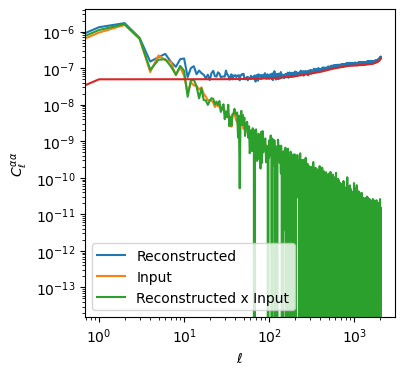

In [14]:
plt.figure(figsize=(4,4))
plt.loglog(cl_recon,label='Reconstructed')
plt.loglog(cl_input,label='Input')
plt.loglog(cl_r_i,label='Reconstructed x Input')
plt.loglog(norm[0])
#plt.ylim(1e-13,1e-2)
plt.xlabel(r'$\ell$')
plt.ylabel(r"$C_\ell^{\alpha \alpha}$")
plt.legend()